# Variational AutoEncoder
## Credit to http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/

In [1]:
from keras.datasets import mnist
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255
x_test = x_test.reshape(-1, 784) / 255

Using TensorFlow backend.


In [2]:
print(x_train.shape,x_test.shape)

(60000, 784) (10000, 784)


In [3]:
from keras.layers import Layer
from tensorflow.python import keras
from keras import objectives

In [4]:
from keras.models import Sequential

In [18]:
from scipy.stats import norm

In [12]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


In [6]:
image_size = x_train.shape[1]
original_dim = image_size 

# network parameters
input_shape = (original_dim, ) # 784
intermediate_dim = 512
batch_size = 100
latent_dim = 2

epochs = 50

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

In [7]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [8]:
#keras.layers.Add()
from keras.layers import Add, Multiply

In [13]:

# network parameters
input_shape = (original_dim, ) # 784
intermediate_dim = 512
batch_size = 100
latent_dim = 2

epochs = 50


x = Input(shape=(original_dim,))
print(x.shape)
h = Dense(intermediate_dim, activation='relu')(x)
print(h.shape)
z_mu = Dense(latent_dim)(h)
print(z_mu.shape)
z_log_var = Dense(latent_dim)(h)
print(z_log_var.shape)
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var) #######
print(z_sigma.shape)

# sample eps
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0],
                                          latent_dim)))
print(eps.shape)
# f_sigma multiply with eps
z_eps = Multiply()([z_sigma, eps])
# add with f_mu
z = Add()([z_mu, z_eps])

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = decoder(z)

(?, 784)
(?, 512)
(?, 2)
(?, 2)
(?, 2)
(?, 2)


In [14]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

In [15]:
#Variational autoencoder architecture for the MNIST digits dataset.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 100us/step - loss: 186.0136 - val_loss: 169.9082
Epoch 2/50
60000/60000 [==============================] - 5s 83us/step - loss: 167.9171 - val_loss: 165.9882
Epoch 3/50
60000/60000 [==============================] - 5s 83us/step - loss: 164.5803 - val_loss: 163.8016
Epoch 4/50
60000/60000 [==============================] - 5s 84us/step - loss: 162.6422 - val_loss: 162.1710
Epoch 5/50
60000/60000 [==============================] - 5s 84us/step - loss: 161.0859 - val_loss: 160.6503
Epoch 6/50
60000/60000 [==============================] - 5s 84us/step - loss: 159.6950 - val_loss: 159.2145
Epoch 7/50
60000/60000 [==============================] - 5s 83us/step - loss: 158.4374 - val_loss: 158.2257
Epoch 8/50
60000/60000 [==============================] - 5s 83us/step - loss: 157.4142 - val_loss: 157.3083
Epoch 9/50
60000/60000 [==============================] - 5s 84us/step - loss

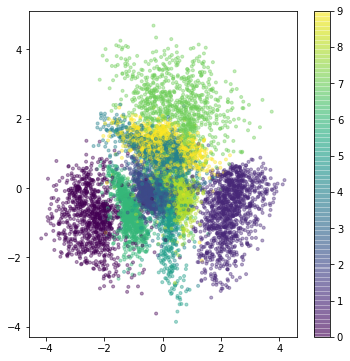

In [16]:
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

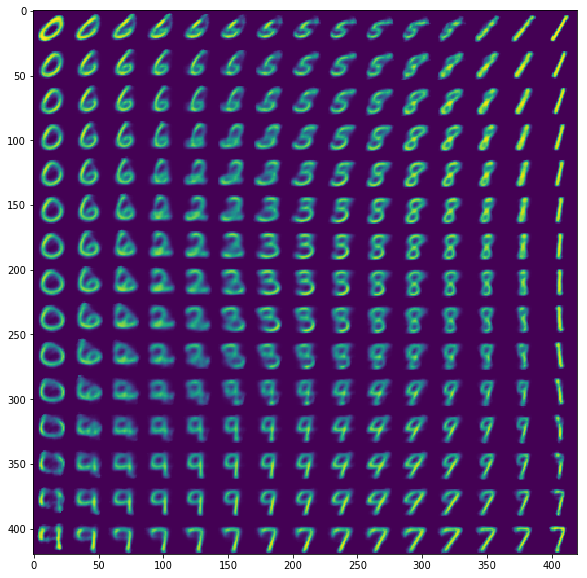

In [20]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='viridis')
plt.show()

### Theory part
Using the fully connected layers Neural Network, train to transform the input image array $x$ into latent Gaussian variable space $z \in \mathcal{Z}$. 
Target is to produce the sampler: 
$$ p(x|z;\lambda) = \mathcal{N}(x;f(z;\lambda),\sigma^2I)$$
, where $\lambda = \{\mu=f(z),\sigma\}$ is what we want.

So that we can sample z and decode it to x, and create x-alike objects,
$$z^{(i)}\sim \mathcal{N}(f_{\mu}(x,\lambda),f_{\Sigma}(x,\lambda))$$
by,

$$z^{(i)} \sim f_{\mu}(x;\lambda)+f_{\Sigma}(x;\lambda)^{1/2}\epsilon^{(i)}$$
$$ \epsilon^{(i)} \sim \mathcal{N}(0,I)$$

To approximate the parameters, KL Divergence is used. Consider, 
$$KL[p(x)||q(x)] = \sum_x p(x)log\frac{p(x)}{q(x)}$$
$$q_{\phi}(z_n|x_n) = \mathcal{N}(z_n|\mu_{\phi}(x_n),diag(\sigma^2_{\phi}(x_n)))$$
$$p(z) = \mathcal{N}(z;0,I)$$

It gives, 
$$KL[q_{\phi}(z|x)||p(z)] = -\frac{1}{2}\sum^K_{k=1}(1+log\sigma_k^2-\mu_k^2-\sigma^2_k)$$

